# Figure 2

## Load packages

In [1]:
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Load functions for simulations and plotting

In [2]:
from Golden_Ratio_functions import *

## Figure 2B: Target responses without sinusoidal gain.

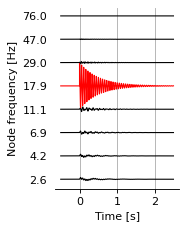

In [3]:
ratio   = (1+np.sqrt(5))/2
f_k     = ratio**np.arange(2,9+1)
network = {"f_k":f_k, "k_perturbed":4}
gain    = {"f_S":0, "g_S":0}

x,t = run_damped_coupled_harmonic_oscillators(network, gain)

f = plt.figure(figsize=(2, 3), dpi=80)
plot_model_traces(t,x,network,gain)
f.savefig("./PDFs/Figure-2B.pdf", bbox_inches='tight')

## Figure 2C: Target responses with sinusoidal gain at frequency $\phi^7$ Hz.

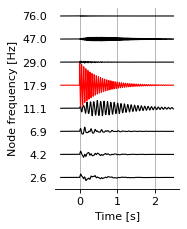

In [4]:
ratio   = (1+np.sqrt(5))/2
f_k     = ratio**np.arange(2,9+1)
network = {"f_k":f_k, "k_perturbed":4}
gain    = {"f_S":ratio**7, "g_S":50}

x,t = run_damped_coupled_harmonic_oscillators(network, gain)

f = plt.figure(figsize=(2, 3), dpi=80)
plot_model_traces(t,x,network,gain)
f.savefig("./PDFs/Figure-2C.pdf", bbox_inches='tight')

## Figure 2D (Part 1): Compute resonant response versus sinusoidal gain frequency, and save it.
This part is slow, and counts from 1 to 100.

In [5]:
ratio   = (1+np.sqrt(5))/2;
f_k     = ratio**np.arange(2,9+1)
network = {"f_k":f_k, "k_perturbed":4}

f_S     = np.arange(1,100,0.1)
g_S     = 50
A       = np.zeros([16,f_S.size])

for i in np.arange(f_S.size):

    print(["%.1f"% f_S[i]][0],end=' ')
    
    gain    = {"f_S":f_S[i], "g_S":g_S}
    x,t = run_damped_coupled_harmonic_oscillators(network, gain)
    
    amp   = np.abs(hilbert(x));
    i0    = np.where( (t>=0) & (t<=1.5) );
    A[:,i]= np.mean(amp[:,i0[0]],1)

res = {"A":A, "f_S":f_S, "g_S":g_S, "f_k":f_k, "network":network, "gain":gain}
io.savemat('Figure-2D.mat', res)

1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0 12.5 13.0 13.5 14.0 14.5 15.0 15.5 16.0 16.5 17.0 17.5 18.0 18.5 19.0 19.5 20.0 20.5 21.0 21.5 22.0 22.5 23.0 23.5 24.0 24.5 25.0 25.5 26.0 26.5 27.0 27.5 28.0 28.5 29.0 29.5 30.0 30.5 31.0 31.5 32.0 32.5 33.0 33.5 34.0 34.5 35.0 35.5 36.0 36.5 37.0 37.5 38.0 38.5 39.0 39.5 40.0 40.5 41.0 41.5 42.0 42.5 43.0 43.5 44.0 44.5 45.0 45.5 46.0 46.5 47.0 47.5 48.0 48.5 49.0 49.5 50.0 50.5 51.0 51.5 52.0 52.5 53.0 53.5 54.0 54.5 55.0 55.5 56.0 56.5 57.0 57.5 58.0 58.5 59.0 59.5 60.0 60.5 61.0 61.5 62.0 62.5 63.0 63.5 64.0 64.5 65.0 65.5 66.0 66.5 67.0 67.5 68.0 68.5 69.0 69.5 70.0 70.5 71.0 71.5 72.0 72.5 73.0 73.5 74.0 74.5 75.0 75.5 76.0 76.5 77.0 77.5 78.0 78.5 79.0 79.5 80.0 80.5 81.0 81.5 82.0 82.5 83.0 83.5 84.0 84.5 85.0 85.5 86.0 86.5 87.0 87.5 88.0 88.5 89.0 89.5 90.0 90.5 91.0 91.5 92.0 92.5 93.0 93.5 94.0 94.5 95.0 95.5 96.0 96.5 97.0 97.5 98.0 98.5 99.0 99.5 

## Figure 2D (Part 2): Load resonant response versus sinusoidal gain frequency, and plot it.

This part is fast.

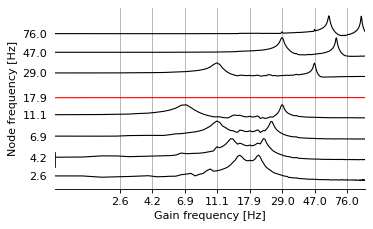

In [5]:
res = io.loadmat("Figure-2D.mat");
f = plt.figure(figsize=(5, 3), dpi=80)
plot_gain_traces(res)
f.savefig("./PDFs/Figure-2D.pdf", bbox_inches='tight')